# Sympy: Plan Risk (beta-PERT)

On the Infinity Project, we have **Plans**, which are composed of **Steps** (step hierarchy). When a person builds a plan, one has an option to describe the investables and deliverables on each step, like:

<hr>

    plan_tuples = [
     (Step[1].investables, Step[1].deliverables),
     (Step[2].investables, Step[2].deliverables),
     ...
     (Step[N].investables, Step[N].deliverables)
    ]

<hr>

We use syntax described by the following examples:

**Step[M].investables**:

    programmer person-days: 10~12@50usd; analyst person-days: 11~45@45usd; software package: 1@159.99usd

**Step[M].deliverables**:

    complete solar assembly drawings: 0~1; solar cell assemblies: 1~2[likely(1.8)]@5.5~5.9[likely(5.8)]h
    
We parse this using [StepIO](https://github.com/WeFindX/StepIO), so, for example:

    solar cell assemblies: 1~2[likely(1.8)]@5.5~5.9[likely(5.8)]usd

parses into:

 - ITEM='solar cell assemblies'
     1. MIN_UNITS = 1
     2. MAX_UNITS = 2
     3. FORMULA_UNITS = 'likely(1.8)'
     4. MIN_PRICE = 5.5
     5. MAX_PRICE = 5.9
     6. FORMULA_PRICE = 'likely(5.8)'
     7. PRICE_UNIT = 'usd'

The FORMULA____ is intended for probability distribution associated with quantity before the squre brackets, and allows flexible modelling of asset values based on our expected amount, and expected price of the value, since each can have a probability distribution associated.

We initially plan to use the time-honored beta-PERT distribution. Since we don't want to use heavy library like **scipy**, let's look at how we could use **sympy** to get the formula, and compute distribution values.

# beta

In [1]:
import sympy

In [2]:
from sympy.stats import Beta, density
from sympy import Symbol

# α, β
a = Symbol('α', positive=True)
b = Symbol('β', positive=True)
B = Beta('B', a, b)

Let's get its general distribution (pdf) formula, and print specific parametrization:

In [3]:
x = Symbol('x')
beta_pdf = density(B)(x)
beta_pdf

x**(α - 1)*(-x + 1)**(β - 1)/beta(α, β)

In [4]:
my_beta_pdf = beta_pdf.subs({a: 2, b: 5})
my_beta_pdf

x*(-x + 1)**4/beta(2, 5)

Let's integrate to make sure it sums to unitary area.

In [5]:
from sympy import Integral

Integral(my_beta_pdf, (x,0,1)).doit().n()

1.00000000000000

Plot it:

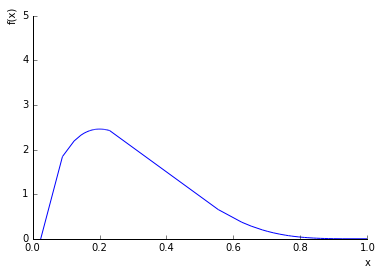

In [6]:
%matplotlib inline
from sympy import plot

plot(my_beta_pdf, xlim=[0, 1], ylim=[0,5]);

It does look coorect. We can play with parameters.

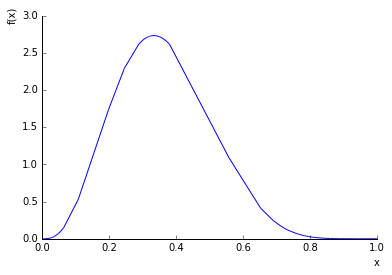

In [7]:
plot(beta_pdf.subs({a: 4, b: 7}), xlim=[0, 1], ylim=[0,3]);

In [8]:
# FYI: from sympy.stats import Normal
#      Z = Normal('Z', 0, 1)
#      density(Z)(x)

More SymPy distributions [here](http://docs.sympy.org/latest/modules/stats.html).

# PERT

**PERT** Stands for **P**rogram **E**valuation and **R**eview **T**echnique by Malcolm et al, 1959. It was initially known as the Program Evaluation and Review Task. The task to which this refers was assessing the uncertainty in the plans for the development schedule and cost for the [Polaris weapon system](https://en.wikipedia.org/wiki/UK_Polaris_programme) [[1](http://broadleaf.com.au/resource-material/beta-pert-origins/)]. However, over time, it had found its was into project planning in general.

It provides a kind of heuristic to compute parameters $\alpha$ and $\beta$ for the Beta distribution, based on 3 pieces of information for every asset:

- A -- the min amount
- M -- the most likely amount
- B -- the max amount

As [we know](https://en.wikipedia.org/wiki/Beta_distribution), the [mean](https://en.wikipedia.org/wiki/Beta_distribution#Mean) of Beta distribution is $$Mean = \frac{1}{1+\frac{\beta}{\alpha}},$$ and [variance](https://en.wikipedia.org/wiki/Beta_distribution#Variance) is: $$Variance = \frac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)}.$$

In [9]:
mean = 1/(1+(a/b)); variance = (a*b)/((a+b)**2*(a+b+1))
'mean: ', mean, 'variance: ', variance

('mean: ', 1/(α/β + 1), 'variance: ', α*β/((α + β)**2*(α + β + 1)))

PERT gives a heuristic to compute the $\mu$ and $\sigma$, namely:

$$\mu = \frac{A + 4M + B}{6}$$

$$\sigma = \left( \frac{B - A}{6} \right)^2$$

So, let's say that we know some specific interval, e.g., [A=0., B=1.], with most likely value is M=0.9. Then, according to PERT, we have:

$$\mu = \frac{0. + (4 \times 0.9) + 1.}{6} = 0.7666... $$

$$\sigma = \left( \frac{1. - 0.}{6} \right)^2 = 0.0277...$$

Based on that, we can solve the system of equations to find $\alpha$, $\beta$:

In [10]:
A = 0.
M = 0.9
B = 1.
mu = (A+(4.*M)+B)/6.; sigma = ((A-B)/6.)**2; mu, sigma

(0.7666666666666666, 0.027777777777777776)

Solving them with hand by substitution, results in:

$$Mean = \frac{1}{1+\frac{\beta}{\alpha}}$$
<hr>
$$ \alpha = \frac{ \mu \beta }{ 1 - \mu }$$



In [11]:
from sympy import Eq, solve
miu = Symbol('μ')
alpha = solve(Eq(1/(1+(b/a)), miu), a)[0]; alpha

-β*μ/(μ - 1)

$$Variance = \frac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$$

<hr>

$$\sigma = \frac{ \frac{\mu\beta}{1-\mu} \beta}{( \frac{\mu\beta}{1-\mu} +\beta)^2( \frac{\mu\beta}{1-\mu} +\beta+1)}$$

In [12]:
sig = Symbol('σ')
numerator = alpha*b
denominator = (alpha + b)**2 * (alpha + b + 1)
beta = solve(Eq((numerator/denominator), sig), b)[0]; beta

(μ - 1)*(μ**2 - μ + σ)/σ

Since $\mu$ and $\sigma$ as given by PERT, we can compute the $\alpha$, $\beta$:

In [13]:
be = beta.subs({sig: sigma, miu: mu}); al = alpha.subs({miu:mu,b:be});
([a,al],[b,be])

([α, 4.17066666666667], [β, 1.26933333333333])

Having the values of Beta distribution, now we can try to plot it again.

In [14]:
beta_pdf

x**(α - 1)*(-x + 1)**(β - 1)/beta(α, β)

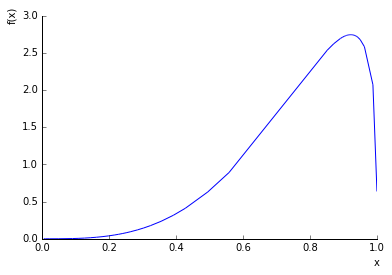

In [15]:
plot(beta_pdf.subs({a: al, b: be}), xlim=[0, 1], ylim=[0,3]);

In [16]:
beta_pdf.subs({a: al, b: be})

7.05509556982414*x**3.17066666666667*(-x + 1)**0.269333333333333

It seem to work well, when $A < M < B$, and $A,M,B \in [0, 1]$.

# betaPERT

While PERT gives mean and variance to use with any distribution, if you would try the above with Beta distribution, you would get errors. To use PERT with Beta distribution for intervals other than $[0,1]$, we should need to normalize and shift data to unitary interval before computing PERT.

{'A': 0.0, 'B': 1.0, 'M': 0.7600000000000001}


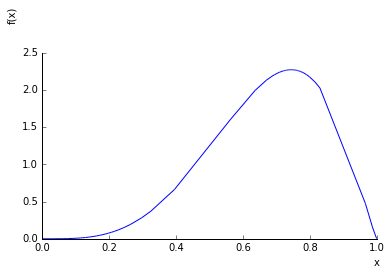

37.3194769245855*x**3.65838933333333*(-x + 1)**1.26001066666667

In [17]:
from sympy import Symbol
from sympy.stats import Beta, density

miu = Symbol('μ')
sig = Symbol('σ')
a = Symbol('α', positive=True)
b = Symbol('β', positive=True)
B = Beta('B', a, b)
x = Symbol('x')
beta_pdf = density(B)(x)

def pertBETA(A=0.,M=0.9,B=1., normalize=True):

    def PERT(A=0.,M=0.9,B=1., normalize=False):
        if normalize:
            Max = max(A,M,B)
            Min = min(A,M,B)
            standardize = -(Min+Max)/2.
            normalize = Max-Min
            A = (float(A) + standardize)/normalize + 0.5
            M = (float(M) + standardize)/normalize + 0.5
            B = (float(B) + standardize)/normalize + 0.5
            print {'A': A, 'M': M, 'B': B}
        mean = (A+(4.*M)+B)/6.
        variance = ((A-B)/6.)**2.
        return {'mean': mean, 'variance': variance}

    def beta_params(mean=0.766, variance=0.027):
        alpha = -b*miu/(miu-1)
        beta = (miu-1)*(miu**2-miu+sig)/sig
        beta = beta.subs({miu:mean,sig:variance})
        alpha = alpha.subs({miu:mean,b:beta})
        return {a:alpha, b:beta}

    def pert_beta(A=0.,M=0.9,B=1.):
        return beta_pdf.subs(
            beta_params(
                **PERT(A,M,B, normalize)
            )
        )
    
    return pert_beta(A,M,B)

%matplotlib inline
from sympy import plot
#dist = pertBETA(0.,0.1,1.)
dist = pertBETA(10.,13.8,15.)
plot(dist,xlim=[0,1],ylim=[0,3])
dist

This concludes the section about **PERT**, and **betaPERT**.

# probPERT

While the **betaPERT** works well in most cases, what it lacks, is the ability to specify the exact probabilities associated with the extreme scenarios. However, sometimes, when the benefit or damage of an event is sufficiently large, you should take actions or bets regarding it, even if the chance of the event is small.

However, when it comes to events with small likelihood, we want to assigne very specific probabilities to the extreme events. For example, probability of an asteroid of specific size hitting the Earth might be $0.0000000001314$, and we may want to include that. More precisely, we could have a specific number of such asteroids expected to fall on Earth, and very small probabilities associated with them, while very large probability associated with zero.

Users may not really want to have to enter the probability of zero, but rather, several very small probabilities in the interval $[1,5]$, saying, that the probability that probability of $1$ asteroid is 0.0000000001314, and probability of $5$ is, say 0.00000000004514.

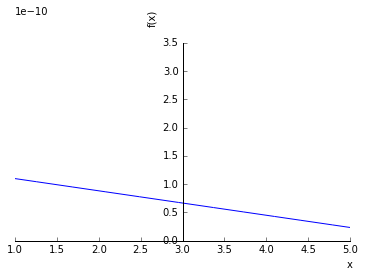

In [18]:
x = Symbol('x')
y_min = 0.00000000004514
y_max = 0.0000000001314
x_min = 1.
x_max = 5.
k = -(y_max-y_min)/(x_max-x_min)
p = y_max+x*k
plot(p, xlim=[x_min,x_max],ylim=[0.,3*y_max]);

The integral of the **AUC** under this curve is merely $2.6682 \times 10^{-10}$, the probability under it is very small.

In [19]:
auc = Integral(p, (x,1,5)).doit().n(); auc

2.66820000000000e-10

What the person cares about, is this interval. So, we really don't want to draw full probability distribution associated with this interval. However, still, in this interval of unfortunate events, we might want to represent a reasonable skewness towards the more likely event.

One way to do it would be to choose some most likely number M, as in **PERT**, add a distribution, and adjust it for endpoints to match the actual estimates.

So, let's consider the mean (the most likely) to be close to the more likely end:

In [20]:
M = lambda A,B: B/(A+B)

Here, if probability line is increasing, choose the value closer to one in [0,1] interval.

{'A': 0.0, 'B': 1.0, 'M': 0.17671089123753836}


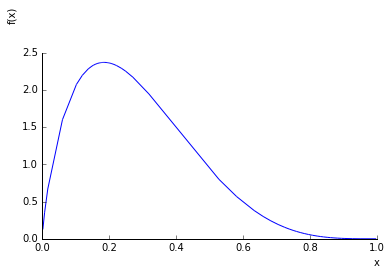

In [21]:
most_likely = M(A=p.subs({x:x_min}),B=p.subs({x:x_max}))
dist = pertBETA(0.,most_likely,1.)
plot(dist,xlim=[0,1],ylim=[0,3]);

Since the $AUC = 1$ here, we would probably like to multiply it by the mean of $(A+B)/2$ to bring it to scale:

In [22]:
f = dist*(p.subs({x:x_min})+p.subs({x:x_max}))/2.; f

1.255514287648e-9*x**0.800078880390687*(-x + 1)**3.52766755409849

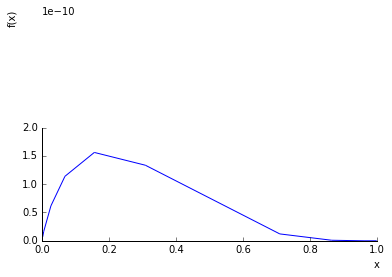

In [23]:
plot(f, xlim=[0.,1.],ylim=[0.,3*y_max]);

Now, the support of the distribution is obviously not the same. it is in $[0,1]$, rather than $[1, 5]$. We can can shift it as a function by transforming $x$:

In [24]:
tf = lambda f: f*(p.subs({x:x_min})+p.subs({x:x_max}))/2
tx = lambda x: (x-x_min)/(x_max-x_min)

In [25]:
dist

18.821891726977*x**0.800078880390687*(-x + 1)**3.52766755409849

In [26]:
dist.args[0]*x**dist.args[1].args[1]*(-x+1)**dist.args[2].args[1]

18.821891726977*x**0.800078880390687*(-x + 1)**3.52766755409849

In [27]:
g = tf(
  dist.args[0]*tx(x)**dist.args[1].args[1]*(-tx(x)+1)**dist.args[2].args[1]
)

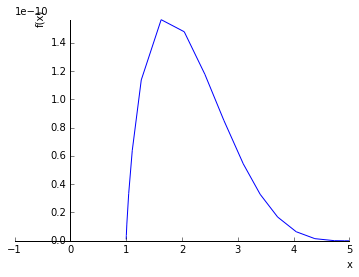

In [28]:
plot(g, xlim=[-1.,5.],ylim=[0.,1.2*y_max]);

Now, we can simply include $g$ into $p$ with some constants to smoothen it, e.g.:

In [29]:
mix = lambda p, q, c: (1-c)*p+c*q

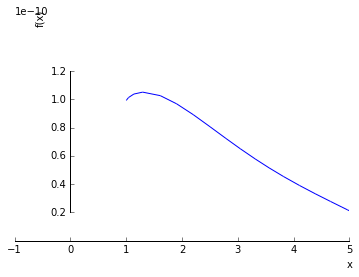

In [30]:
plot(mix(p,g,0.1), xlim=[-1.,5.],ylim=[0.,1.2*y_max]);

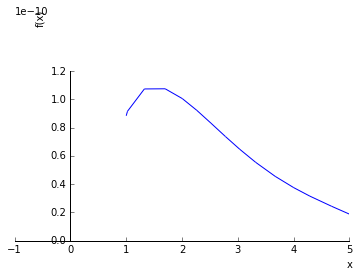

In [31]:
plot(mix(p,g,0.2), xlim=[-1.,5.],ylim=[0.,1.2*y_max]);